# REGRESSÃO

Este modelo **prevê o número de passageiros pagos** em um voo com certas características, assim permitindo uma estimativa da taxa de ocupação.

___
## Bibliotecas

In [1]:
# Básico para Data Science
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import pickle

# Pipeline / Transformação
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Avaliação de performance dos modelos
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

# Otimização
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

# Configurando exibição dos datasets
pd.options.display.max_rows = 100 # máximo de 100 linhas a serem exibidas
pd.options.display.max_columns = 100 # máximo de 100 colunas a serem exibidas

# Faz com que todos os plots tenham o estilo do seaborn
sns.set_theme()

# Ignora avisos
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

___
### Carregando e inspecionando a base

In [14]:
# # Rodar direto do ambiente de produção
# df = pd.read_csv('/gdrive/MyDrive/Projeto_DS/Ambiente_Producao/datalake/business+/basica_passagem_dolar_completa_2016-2021.csv', sep=';', encoding='latin1', low_memory=False)

# Rodar em ambiente local, fazendo o download do arquivo 'base_grupo_3.zip'
# https://drive.google.com/file/d/14VMbZXQssmIMOJQRlUMMyewoEQg2v5hB/view?usp=sharing
from zipfile import ZipFile
zip_file = ZipFile('E:/backup/Projeto Final QADS/base_grupo_3.zip')
df = pd.read_csv(zip_file.open('base_grupo_3.csv'),sep=';', encoding='latin-1')

In [15]:
df.head()

,dt,nr_ano,nr_mes,nr_dia,nm_dia_semana,sg_empresa_icao,hr_partida_real,hr_chegada_real,sg_icao_origem,sg_icao_destino,nm_regiao_origem,nm_regiao_destino,sg_uf_origem,sg_uf_destino,sg_equipamento_icao,km_distancia,nr_horas_voadas,lt_combustivel,nr_assentos_ofertados,nr_passag_pagos,nr_passag_gratis,kg_payload,kg_peso,kg_carga_paga,kg_carga_gratis,kg_correio,nr_ask,nr_rpk,nr_atk,nr_rtk,lf_passag,lf_peso,rend_combustivel,dolar,ticket_medio
0,2016-01-02,2016,1,2,SAB,ONE,05:58:00,09:01:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.05,8480,162,156,0,18100,14027,0,0,0,311040.0,299520.0,34752.0,26931.0,0.962963,0.774948,0.2264,3.9973,540.0
1,2016-01-03,2016,1,3,DOM,ONE,05:53:00,08:57:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.07,9009,162,158,1,18500,14134,0,0,0,311040.0,303360.0,35520.0,26993.0,0.975309,0.759938,0.2131,3.9973,540.0
2,2016-01-04,2016,1,4,SEG,ONE,06:00:00,09:05:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.08,8758,162,162,0,18500,14508,0,0,0,311040.0,311040.0,35520.0,27855.0,1.000000,0.784206,0.2192,3.9973,540.0
3,2016-01-05,2016,1,5,TER,ONE,05:59:00,08:59:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.00,8512,162,144,3,18500,12995,38,0,0,311040.0,276480.0,35520.0,24518.0,0.888889,0.690259,0.2256,3.9973,540.0
4,2016-01-06,2016,1,6,QUA,ONE,05:55:00,09:00:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.08,8498,162,131,1,18500,11750,33,0,0,311040.0,251520.0,35520.0,22416.0,0.808642,0.631081,0.2259,3.9973,540.0


## Diminuindo uso de memória do Dataset

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3686261 entries, 0 to 3686260
Data columns (total 35 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   dt                     object 
 1   nr_ano                 int64  
 2   nr_mes                 int64  
 3   nr_dia                 int64  
 4   nm_dia_semana          object 
 5   sg_empresa_icao        object 
 6   hr_partida_real        object 
 7   hr_chegada_real        object 
 8   sg_icao_origem         object 
 9   sg_icao_destino        object 
 10  nm_regiao_origem       object 
 11  nm_regiao_destino      object 
 12  sg_uf_origem           object 
 13  sg_uf_destino          object 
 14  sg_equipamento_icao    object 
 15  km_distancia           float64
 16  nr_horas_voadas        float64
 17  lt_combustivel         int64  
 18  nr_assentos_ofertados  int64  
 19  nr_passag_pagos        int64  
 20  nr_passag_gratis       int64  
 21  kg_payload             int64  
 22  kg_peso           

In [17]:
for column in df.columns:
    if np.issubdtype(df[column], np.integer) == True:
        df[column] = df[column].astype(np.int32)

In [18]:
colunas_int16 = [
    'nr_ano', 
     'km_distancia', 
     'lt_combustivel', 
     'nr_assentos_ofertados', 
     'nr_passag_pagos', 
     'kg_correio', 
     'nr_ano',
     'ticket_medio'
]

In [19]:
colunas_int8 = [
    'nr_mes',
    'nr_dia',
    'nr_dia',
    'nr_horas_voadas',
    'nr_passag_gratis',
    'mes'
]

In [20]:
for column in colunas_int16:
    df[column] = df[column].astype(np.int16)
# for column in colunas_int8:
#     df[column] = df[column].astype(np.int8)

In [21]:
for column in df.columns:
    if np.issubdtype(df[column], np.float_) == True:
        df[column] = df[column].astype(np.float32)

In [22]:
for column in df.columns:
    if column == 'dt':
        continue
    elif df[column].dtype.name == 'object':
        df[column] = df[column].astype('category')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3686261 entries, 0 to 3686260
Data columns (total 35 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   dt                     object  
 1   nr_ano                 int16   
 2   nr_mes                 int32   
 3   nr_dia                 int32   
 4   nm_dia_semana          category
 5   sg_empresa_icao        category
 6   hr_partida_real        category
 7   hr_chegada_real        category
 8   sg_icao_origem         category
 9   sg_icao_destino        category
 10  nm_regiao_origem       category
 11  nm_regiao_destino      category
 12  sg_uf_origem           category
 13  sg_uf_destino          category
 14  sg_equipamento_icao    category
 15  km_distancia           int16   
 16  nr_horas_voadas        float32 
 17  lt_combustivel         int16   
 18  nr_assentos_ofertados  int16   
 19  nr_passag_pagos        int16   
 20  nr_passag_gratis       int32   
 21  kg_payload             int32   

In [24]:
df.head()

,dt,nr_ano,nr_mes,nr_dia,nm_dia_semana,sg_empresa_icao,hr_partida_real,hr_chegada_real,sg_icao_origem,sg_icao_destino,nm_regiao_origem,nm_regiao_destino,sg_uf_origem,sg_uf_destino,sg_equipamento_icao,km_distancia,nr_horas_voadas,lt_combustivel,nr_assentos_ofertados,nr_passag_pagos,nr_passag_gratis,kg_payload,kg_peso,kg_carga_paga,kg_carga_gratis,kg_correio,nr_ask,nr_rpk,nr_atk,nr_rtk,lf_passag,lf_peso,rend_combustivel,dolar,ticket_medio
0,2016-01-02,2016,1,2,SAB,ONE,05:58:00,09:01:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920,3.05,8480,162,156,0,18100,14027,0,0,0,311040.0,299520.0,34752.0,26931.0,0.962963,0.774948,0.2264,3.9973,540
1,2016-01-03,2016,1,3,DOM,ONE,05:53:00,08:57:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920,3.07,9009,162,158,1,18500,14134,0,0,0,311040.0,303360.0,35520.0,26993.0,0.975309,0.759938,0.2131,3.9973,540
2,2016-01-04,2016,1,4,SEG,ONE,06:00:00,09:05:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920,3.08,8758,162,162,0,18500,14508,0,0,0,311040.0,311040.0,35520.0,27855.0,1.000000,0.784206,0.2192,3.9973,540
3,2016-01-05,2016,1,5,TER,ONE,05:59:00,08:59:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920,3.00,8512,162,144,3,18500,12995,38,0,0,311040.0,276480.0,35520.0,24518.0,0.888889,0.690259,0.2256,3.9973,540
4,2016-01-06,2016,1,6,QUA,ONE,05:55:00,09:00:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920,3.08,8498,162,131,1,18500,11750,33,0,0,311040.0,251520.0,35520.0,22416.0,0.808642,0.631081,0.2259,3.9973,540


# Primeira Seleção de Features 

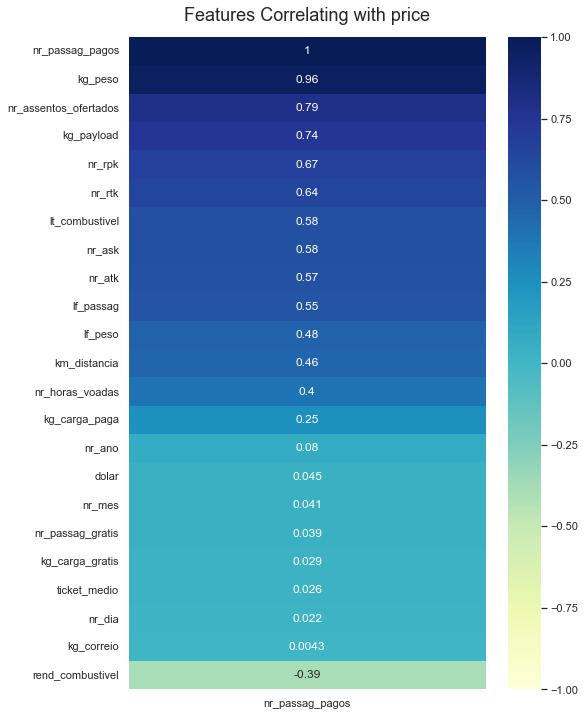

In [25]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['nr_passag_pagos']].sort_values(by='nr_passag_pagos', ascending=False), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')
heatmap.set_title('Features Correlating with price', fontdict={'fontsize':18}, pad=16);

In [26]:
colunas = [
    'dt',
    'nm_dia_semana',
    'hr_partida_real',
    'hr_chegada_real',
    'sg_equipamento_icao',
    'km_distancia',
    'nr_horas_voadas',
    'lt_combustivel',
    'nr_assentos_ofertados',
    'nr_passag_pagos',
    'kg_payload',
    'rend_combustivel',
    'dolar',
    'nr_ano',
    'nr_mes',
    'sg_empresa_icao',
    'sg_icao_origem',
    'sg_icao_destino',
    'ticket_medio'
]

In [27]:
df_tratado = df[colunas]

In [28]:
df_tratado.head()

,dt,nm_dia_semana,hr_partida_real,hr_chegada_real,sg_equipamento_icao,km_distancia,nr_horas_voadas,lt_combustivel,nr_assentos_ofertados,nr_passag_pagos,kg_payload,rend_combustivel,dolar,nr_ano,nr_mes,sg_empresa_icao,sg_icao_origem,sg_icao_destino,ticket_medio
0,2016-01-02,SAB,05:58:00,09:01:00,A320,1920,3.05,8480,162,156,18100,0.2264,3.9973,2016,1,ONE,SBMO,SBGR,540
1,2016-01-03,DOM,05:53:00,08:57:00,A320,1920,3.07,9009,162,158,18500,0.2131,3.9973,2016,1,ONE,SBMO,SBGR,540
2,2016-01-04,SEG,06:00:00,09:05:00,A320,1920,3.08,8758,162,162,18500,0.2192,3.9973,2016,1,ONE,SBMO,SBGR,540
3,2016-01-05,TER,05:59:00,08:59:00,A320,1920,3.00,8512,162,144,18500,0.2256,3.9973,2016,1,ONE,SBMO,SBGR,540
4,2016-01-06,QUA,05:55:00,09:00:00,A320,1920,3.08,8498,162,131,18500,0.2259,3.9973,2016,1,ONE,SBMO,SBGR,540


In [29]:
def editar(x): 
    x = re.sub("[^0-9]", "", str(x))
    return x[0:2]
df_tratado['hr_partida_real'] = df_tratado['hr_partida_real'].apply(editar)
df_tratado['hr_chegada_real'] = df_tratado['hr_chegada_real'].apply(editar)

In [30]:
df_tratado = df_tratado[(df_tratado['sg_empresa_icao'] == 'AZU') | (df_tratado['sg_empresa_icao'] == 'GLO') | (df_tratado['sg_empresa_icao'] == 'TAM')]

In [31]:
df_tratado.head()

,dt,nm_dia_semana,hr_partida_real,hr_chegada_real,sg_equipamento_icao,km_distancia,nr_horas_voadas,lt_combustivel,nr_assentos_ofertados,nr_passag_pagos,kg_payload,rend_combustivel,dolar,nr_ano,nr_mes,sg_empresa_icao,sg_icao_origem,sg_icao_destino,ticket_medio
5780,2016-01-01,SEX,06,07,E195,349,0.83,1928,118,105,16143,0.1810,3.9973,2016,1,AZU,SBCT,SBKP,330
5781,2016-01-03,DOM,20,21,E190,349,1.00,2025,106,76,12858,0.1723,3.9973,2016,1,AZU,SBCT,SBKP,330
5782,2016-01-03,DOM,07,08,E195,349,0.98,2075,118,106,13493,0.1682,3.9973,2016,1,AZU,SBCT,SBKP,330
5783,2016-01-03,DOM,10,11,E190,349,0.92,1899,106,86,12858,0.1838,3.9973,2016,1,AZU,SBCT,SBKP,330
5784,2016-01-04,SEG,10,11,E195,349,0.92,1914,118,93,13493,0.1823,3.9973,2016,1,AZU,SBCT,SBKP,330


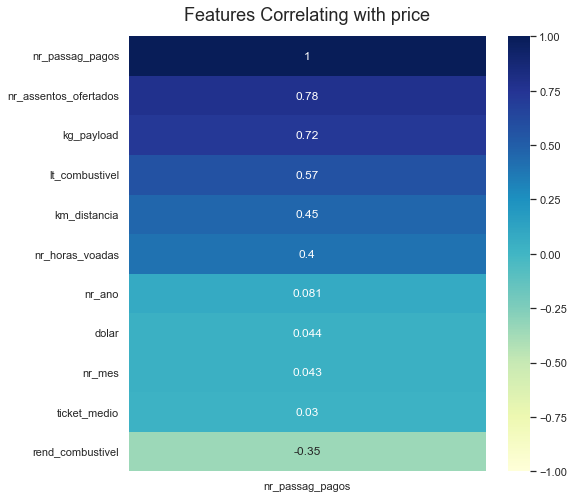

In [32]:
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(df_tratado.corr()[['nr_passag_pagos']].sort_values(by='nr_passag_pagos', ascending=False), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')
heatmap.set_title('Features Correlating with price', fontdict={'fontsize':18}, pad=16);

# Seleção final das features

In [47]:
num_col = [
    'km_distancia',
    'nr_horas_voadas',
    'lt_combustivel',
    'nr_assentos_ofertados',
    'kg_payload',
    'rend_combustivel',
    'ticket_medio'
]

cat_col = [
    'nr_ano',
    'nr_mes',
    'nm_dia_semana',
    'sg_equipamento_icao',
    'sg_empresa_icao',
    'sg_icao_origem',
    'sg_icao_destino',
    'hr_partida_real',
    'hr_chegada_real',
]

target = ['nr_passag_pagos']

In [48]:
df_final = df_tratado[cat_col + num_col + target]

Dividimos em dois datasets, um com os anos de 2017 a 2019 e outro somente dos anos de ocorrencia do covid

In [49]:
df_modelo_2017_19 = df_final[(df_final['nr_ano'] > 2016) & (df_final['nr_ano'] <= 2019)]
df_modelo_2020_21 = df_final[df_final['nr_ano'] > 2019]

# Dividindo o Dataset

In [38]:
X = df_modelo_2017_19.drop('nr_passag_pagos', axis=1)
y = df_modelo_2017_19['nr_passag_pagos']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Redução de Dimensionalidade com PCA
cuidado com essa parte no colab, pode dar erro por conta da memoria disponibilizada

In [51]:
X_train_pca = pd.get_dummies(X_train[cat_col])

Essa forma de PCA da um suspiro pra memória!!

In [54]:
n_batches = 100
pca = IncrementalPCA(n_components=4)
for X_batch in np.array_split(X_train_pca, n_batches):
  pca.partial_fit(X_batch)
pca.explained_variance_ratio_.sum()*100

72.83133116697407

In [55]:
pca.components_.shape

(4, 387)

In [57]:
X_train_pca_final = pd.DataFrame(data=pca.transform(X_train_pca), columns=[f'pca{i}' for i in range(1, 5)], index=X_train.index)
X_test_pca_final = pd.DataFrame(data=pca.transform(pd.get_dummies(X_test[cat_col])), columns=[f'pca{i}' for i in range(1, 5)], index=X_test.index)

In [58]:
X_train = pd.concat([X_train[num_col], X_train_pca_final], axis=1)
X_test = pd.concat([X_test[num_col], X_test_pca_final], axis=1)

# Treinamento do modelo

In [59]:
steps = [
    ('scaler', MinMaxScaler()),
    ('rfr', RandomForestRegressor(n_estimators=50, max_depth=40, random_state=42, n_jobs=-1))
]

In [60]:
pipe = Pipeline(steps=steps, verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 1.9min


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rfr',
                 RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=-1,
                                       random_state=42))],
         verbose=True)

In [61]:
y_pred = pipe.predict(X_test)

In [62]:
metrics.r2_score(y_test, y_pred)

0.751564925178327

In [ ]:
metrics.mean_absolute_error(y_test, y_pred)

14.22160764766309

## Cross Validation

In [ ]:
cv = cross_validate(pipe, X_train, y_train, verbose=5, cv=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.4min
[CV] END ......................................., score=0.768 total time= 2.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.4min
[CV] END ......................................., score=0.767 total time= 2.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.4min
[CV] END ......................................., score=0.767 total time= 2.4min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.3min remaining:    0.0s


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.4min
[CV] END ......................................., score=0.768 total time= 2.4min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.7min remaining:    0.0s


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.4min
[CV] END ......................................., score=0.766 total time= 2.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.1min finished


In [ ]:
cv['test_score'].mean()

0.7671045806242038

O modelo não está com overfitting!!!!